<a href="https://colab.research.google.com/github/Bryan-Az/ClusteringMethod-Slate/blob/main/Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
# this is the model for anomaly detection, KNN works best for this dataset (univarate)
from pyod.models.knn import KNN
# scaling the data for model interpretability
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Anomaly Detection using pyOD
An uni-variate analysis of audio data using for emotional speech detection. pyOD will be used to run anomaly detection on the dataset. 
1. PyOD (Python Outlier Detection) is an open-source Python library that provides a comprehensive and scalable toolkit for detecting outlying objects in multivariate data.
2. Given my previous results with the Gaussian Mixed Model on the high-dimensional (5 feature) dataframe, I will be running outlier detection using K-Means on a single feature to take a more detailed view and lower the dimensionality & complexity of the results.
## Data Loading

In [5]:
actors_meta_df = pd.read_csv('./data_samples/actors_meta_df.csv')

In [37]:
actors_meta_df.columns

Index(['actor', 'tempo', 'y', 'sr', 'onset_env', 'spectral_centroid',
       'spectral_bandwidth', 'spectral_rolloff', 'zero_crossing_rate',
       'chroma_stft', 'mfcc', 'rmse', 'modality', 'vocal_channel', 'emotion',
       'emotional_intensity', 'statement', 'repetition'],
      dtype='object')

In [33]:
# selecting only our feature of interest, tempo 
tempo = actors_meta_df['tempo']
tempo.describe()

count    1440.000000
mean      125.635374
std        41.601913
min        46.981534
25%        92.285156
50%       123.046875
75%       151.999081
max       258.398438
Name: tempo, dtype: float64

In [34]:
# converting to numpy array, and reshaping to 2D array (each row is a sample array within the array)
tempo = tempo.to_numpy()
tempo = tempo.reshape(-1,1)
print(tempo.shape)

(1440, 1)


In [35]:
# normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
tempo = scaler.fit_transform(tempo)
tempo[:5]

array([[0.17204301],
       [0.11728395],
       [0.24786325],
       [0.54166667],
       [0.02222222]])

## Outlier Detection using pyOD's KNN model

In [36]:
# initializing the model and fitting the data (training the model, creating the decision boundary / predictions)
knn = KNN()
knn.fit(tempo)

KNN(algorithm='auto', contamination=0.1, leaf_size=30, method='largest',
  metric='minkowski', metric_params=None, n_jobs=1, n_neighbors=5, p=2,
  radius=1.0)

### Predicting whether each point is an outlier

In [56]:
# Get the prediction labels
labels = knn.labels_

In [63]:
label_series = pd.Series(labels)
label_series.value_counts()

0    1414
1      26
Name: count, dtype: int64

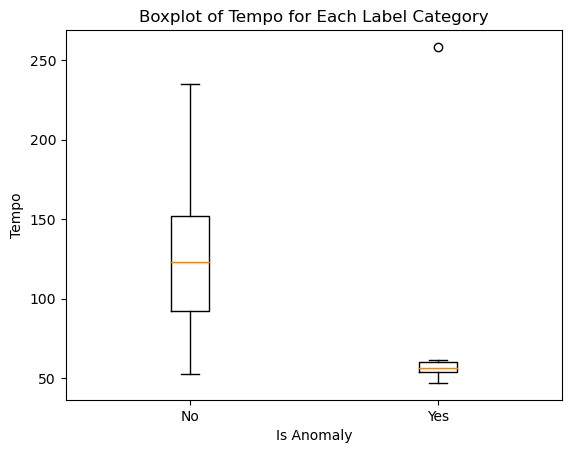

In [81]:
# visualizing the data by plotting the tempo as y and labels as x, with y using a boomstick color map
# create a boxplot of the tempo data with the labels as the x axis
import matplotlib.pyplot as plt

# Using the un-scale tempo data for plotting and interpretation
tempo = actors_meta_df['tempo'].to_numpy()

# Create a list of tempo values for each label category
label_tempo = [tempo[labels == label].flatten() for label in set(labels)]

# Create a boxplot of the tempo data for each label
plt.boxplot(label_tempo, labels=['Yes' if x == 1 else 'No' for x in set(labels)])

# Set the labels and title
plt.xlabel('Is Anomaly')
plt.ylabel('Tempo')
plt.title('Boxplot of Tempo for Each Label Category')

# Show the plot
plt.show()


## Assessing the Anomalies
From the plot above we can see that the majority of the data is not marked as anomaly. The non-anomalous data has a global (average tempo for the whole audio file) tempo value mean of around 125 bpm across the entire dataset, and the boxplot shows us that the upper bound is a tempo of around ~240 bpm and the lower bound is 50bpm. 

The anomalous data has a much smaller range, and a much lower mean. This makes sense given we are seeking anomalies and outliers. The outlier global tempo value boxplot has a mean of around 55 bpm, a lower bound of 45 bpm and a higher bound of 60 bpm. The outlier boxplot also has a surprising data point that goes all the way up to 260 bpm! This shows us that the majority of outliers are of ~ 50-60 bpm for global tempo, and that there's a single high tempo outlier of ~260 bpm.